In [1]:
import numpy as np
from scipy.stats import norm
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pingouin as pg
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)
import warnings
warnings.filterwarnings("ignore") 

/Users/irinaknyazeva/opt/anaconda3/envs/pymc/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/irinaknyazeva/opt/anaconda3/envs/pymc/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
!python --version
print(pm.__version__)
print(az.__version__)
print(pd.__version__)
print(sns.__version__)

Python 3.8.5
3.11.0
0.11.1
1.2.2
0.11.0


# Endowment effect exploration

_In psychology and behavioral economics, the endowment effect is the finding that people are more likely to retain an object they own than acquire that same object when they do not own it._


The task following the gel application required the men to look at photos of 28 items, half of which were considered utilitarian and another one as hedonic. Each product was presented randomly twice during each session (placebo and testosterone), and participants needed to express their value estimation of the item by typing price.
When it was indicated on the photo that they possess an item, participants asked to indicate the minimum amount of money they willing to accept (WTA) to give it up. If it was indicated on the photo that the item possessed by someone else, participants asked to indicate the maximum amount of money they willing to pay (WTP) to acquire it.

The WTA/WTP ratio mesures endowment effect. In this paradigm, willingness to pay (WTP) to acquire an object is typically lower than the least amount they are willing to accept (WTA) to give up that same object when they own it—even when there is no cause for attachment.

The hypotesis to test:
 - There is endowment effect for both type of goods (utilitarian and hedonic), WTA/WTP > 1
 - Endowment effect for hedonic goods bigger then for utilitarian (WTA/WTP)(hedonic) > (WTA/WTP)(utilitarian)
 - Testosterone administration will increase endowment effect, especially for hedonic goods. 

## Hormone data

Testosterone and cortisol serum concentrations were analyzed by electrochemiluminescence immunoassays (ECLIA, Roche® Diagnostics GmbH). For testosterone, the inter-assay coefficient was 2.4 with a lower detection limit of 0.09 nmol/L. Respective inter-assay data for cortisol was 3.8 with a lower detection limit of 0.054 µg/dl. Intra-assay coefficients for testosterone and cortisol were below 3. All analyses were conducted under strict internal and external quality control at the Clinical Chemistry, Haematology, Virology, and Microbiology Laboratory Diagnostic Centre (LDZ) of the RWTH Aachen University Hospital.

In [3]:
#reading hormone data 
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
#handling with missing data
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#merging with the subject keys and hormone change
ids = pd.read_excel('EE_subj_list.xlsx', header=None, usecols = [1,2])
ids.columns = ['ID', 'Subjects']
ids = ids.join(TPl_change, on = ['ID'])

In [4]:
print('Subject list and corresponding testosterone level change (relative to placebo level state at the moment of task performing)')
ids.head()

Subject list and corresponding testosterone level change (relative to placebo level state at the moment of task performing)


,ID,Subjects,TPl_change
0,MR01,Subj1,2.655172
1,MR02,Subj2,0.491713
2,MR03,Subj3,1.287879
3,MR04,Subj4,0.030303
4,MR05,Subj5,0.416894


## Endowment data

In [5]:
df = pd.read_excel('Endowment_list.xlsx')
df1 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTA_Test','WTA_Plac'], value_name='WTA')
df1['Test'] = 0
df1.loc[df1.variable.str.contains('Test'),'Test'] = 1
df1.drop('variable', axis=1, inplace = True)
df2 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTP_Test','WTP_Plac'], value_name='WTP')
df2['Test'] = 0
df2.loc[df2.variable.str.contains('Test'),'Test'] = 1
df2.drop('variable', axis=1, inplace = True)
df = df1.merge(df2)
df.drop(df.index[(df.WTA.isin([0, np.nan])) | (df.WTP.isin([0, np.nan]))], inplace = True)
df = pd.merge(df, ids, on = 'Subjects')
df.loc[df.Test==0, 'TPl_change'] = 0
df['WTA/WTP'] = df.WTA/df.WTP
df = df.drop(['Market Price','WTA','WTP','ID'],axis=1)

In [6]:
#optional: drop individual with inconsistent replies 
df = df[~ df.Subjects.isin(['Subj33'])].reset_index(drop=True)

There is a number of outliers in the data, where WTA exceeds WTP 20 times and more. We decided to clip these values to a reasonable upper boarder equal to mean value with 3 standart deviations added.

In [7]:
max_rel = df['WTA/WTP'].mean()+3*df['WTA/WTP'].std()
df['WTAPcorr'] = df['WTA/WTP']
df.loc[df['WTA/WTP']>max_rel,'WTAPcorr'] = max_rel

In [8]:
df["ItemCodes"] = pd.Categorical(df['Item']).codes
df["SubjectsCode"] = pd.Categorical(df['Subjects']).codes
df["TypeCode"] = pd.Categorical(df['Type']).codes

In [9]:
df.sample(10)

,Subjects,Item,Type,Test,TPl_change,WTA/WTP,WTAPcorr,ItemCodes,SubjectsCode,TypeCode
131,Subj3,powerport,u,1,1.287879,1.083333,1.083333,18,22,1
509,Subj10,chess,h,1,0.067511,1.000000,1.000000,7,1,0
1892,Subj36,powerport,u,0,0.000000,1.000000,1.000000,18,28,1
1806,Subj35,helicopter,h,1,1.222222,1.500000,1.500000,10,27,0
1865,Subj36,micro SD,u,1,0.028902,1.500000,1.500000,14,28,1
935,Subj18,roulette drink game,h,1,0.231707,0.666667,0.666667,19,9,0
1914,Subj37,bottle,u,1,0.557093,0.500000,0.500000,3,29,1
1340,Subj25,joke button,h,0,0.000000,1.200000,1.200000,11,17,0
693,Subj13,roulette drink game,h,0,0.000000,1.000000,1.000000,19,4,0
128,Subj3,gloves,u,1,1.287879,2.400000,2.400000,9,22,1


## Endowment effect exploration

1. **For all type of goods**
 
 - H0 : WTA/WTP = 1
 - H1:  WTA/WTP > 1
 
2. **WTA/WTP(hedonic) > WTA/WTP(utilitarian)** 

 - H0 : WTA/WTP(h) =  WTA/WTP(u)
 - H1:  WTA/WTP(h) >  WTA/WTP(u)

In [10]:
pg.rm_anova(data = df,dv ='WTA/WTP', within = ['Type','Test'], subject = 'Subjects' , correction = 'True')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Type,4.535301,1,36,4.535301,13.151491,0.000882,0.000882,0.267571,1.0
1,Test,0.060394,1,36,0.060394,0.148111,0.702612,0.702612,0.004097,1.0
2,Type * Test,0.012957,1,36,0.012957,0.069741,0.793220,0.793220,0.001934,1.0


### 1. Endowment effect for all type of goods
We tested the first hypothesis with one-sample ttest.  For ttest only placebo data was considered.

In [11]:
pg.ttest(x=df.loc[df.Test==0,'WTA/WTP'],y=1, tail = 'greater')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,11.277051,989,greater,3.918112e-28,"[1.36, inf]",0.358408,5.767e+24,1.0


As a result, we can reject H0 very confidently!!! Bayes factor for supporting alternative is extremely high.

### 2. Comparison of hedonic and utilitarian goods

From the picture we can see little difference between hedonic and utilitarian goods

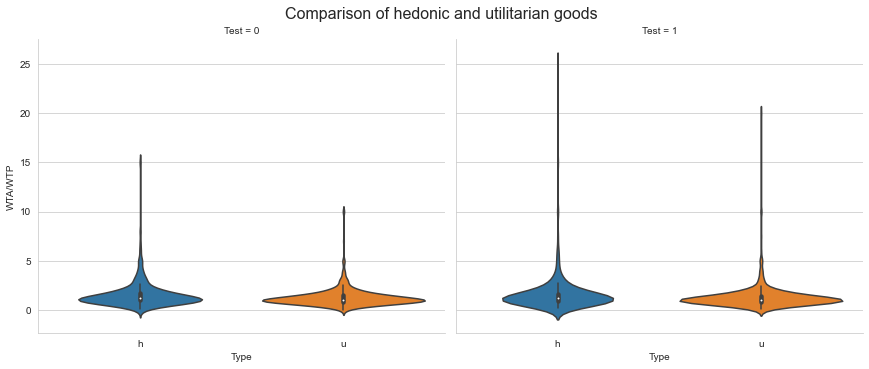

In [12]:
g = sns.catplot(x="Type", y="WTA/WTP",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);
plt.subplots_adjust(top=0.89)

g.fig.suptitle('Comparison of hedonic and utilitarian goods', size = 16);

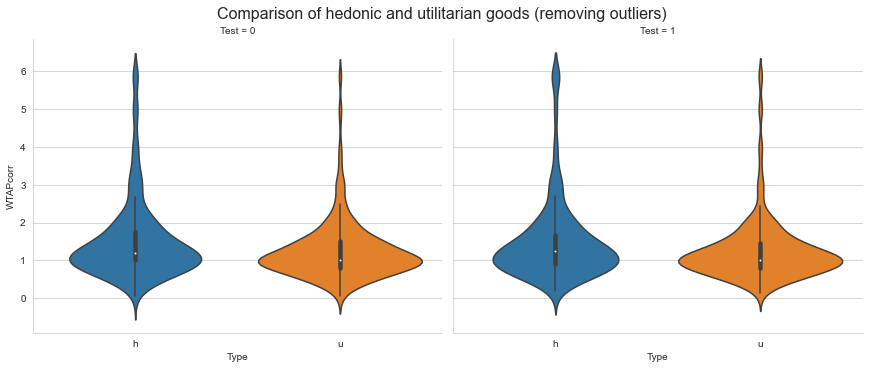

In [13]:
g = sns.catplot(x="Type", y="WTAPcorr",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);
plt.subplots_adjust(top=0.89)
g.fig.suptitle('Comparison of hedonic and utilitarian goods (removing outliers)', size = 16);

In [17]:
df.groupby(['Type','Test'])['WTA/WTP','WTAPcorr'].agg(['mean','std'])

WTA/WTP            WTAPcorr          
               mean       std      mean       std
Type Test                                        
h    0     1.574687  1.389769  1.524370  1.065478
     1     1.665132  2.026490  1.518775  1.101100
u    0     1.280257  0.933393  1.261312  0.790640
     1     1.310067  1.266322  1.262969  0.842129

There is a small problem with the equal variance assumption here. Equal variance is assumed in both data sets for ttest conduction, but here it is violated.

In [63]:
pg.ttest(x=df.loc[(df.Test == 0)&(df.Type == 'h'),'WTA/WTP'], y=df.loc[(df.Test == 0)&(df.Type == 'u'),'WTA/WTP'], correction=False, tail = 'greater').round(9)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.914389,988,greater,0.000048,"[0.17, inf]",0.248815,256.62,0.9883


In [61]:
pg.ttest(x=df.loc[(df.Test == 1)&(df.Type == 'h'),'WTA/WTP'], y=df.loc[(df.Test == 1)&(df.Type == 'u'),'WTA/WTP'], correction=False, tail = 'greater').round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.3617,1020,greater,0.0004,"[0.18, inf]",0.2103,35.795,0.9568


**Conclusion:**
 -  The collected data confirm endowment effect
 - Endowment effect for hedonic goods is greater than for utilitarian ones

### Difference between hedonic and utilitarian goods

We also used Bayesian perspective for answering the same questions about endowment effect.
Additionally, we can draw posterior distribution for WTA/WTP ratio in general and for each item separately. It is also not sensitive to equal variance assumption. 

Linear model (complete pooling): 
$$WTA/WTP = \mu_{Type}$$

Bayseian model: WTA/WTP ratio came from normal distribution with some mean and variance
$$WTA/WTP \sim Normal(\mu_{Type},\sigma_{Type})$$

Prior suggestion: 
informative prior for checking H0 hypothesis:
mean = 1, what corresponds 0 means in lognormal distribution exp(0) = 1 
$$\mu \sim Lognormal(mean = (0,0), sigma = (5,5), size = 2)$$

and uniformative prior for sigma
$$\sigma \sim Exponentional(1)$$


#### Why lognormal???

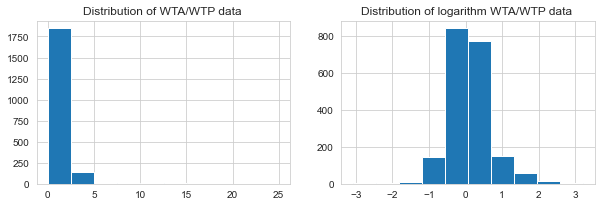

In [33]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1); plt.hist(df['WTA/WTP']);plt.title('Distribution of WTA/WTP data ');
plt.subplot(1,2,2); plt.hist(np.log(df['WTA/WTP'])); plt.title('Distribution of logarithm WTA/WTP data ');
plt.savefig('imgs/'+ 'WTAdist.jpg',dpi = 300, format='jpeg', bbox_inches = 'tight')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 18 seconds.


0, dim: obs_id, 2012 =? 2012


0, dim: obs_id, 2012 =? 2012


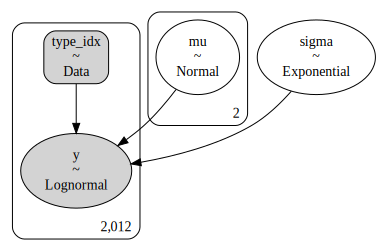

In [16]:
coords = {"GoodType": ["Hedonic", "Utilitarian"], "obs_id": np.arange(df.Type.size)}

with pm.Model(coords=coords) as type_model:
    type_idx = pm.Data("type_idx", df.TypeCode.values, dims="obs_id")
    mu = pm.Normal("mu", 0, sigma=1, dims="GoodType")
    sigma = pm.Exponential('sigma', 2)
    y = pm.Lognormal("y", mu[type_idx], sigma=sigma, observed=df['WTA/WTP'].values, dims="obs_id")
    type_trace = pm.sample(4000, tune=1000, init="adapt_diag")
    ppc = pm.sample_posterior_predictive(type_trace)
    type_idata = az.from_pymc3(type_trace, posterior_predictive=ppc)
pm.model_to_graphviz(type_model)


#### Posterior distribution of mean WTA/WTP for hedonic and utilitarian goods

In [25]:
def effect_size(type_idata):
    means_diff = type_idata.posterior.mu[:,:,0] - type_idata.posterior.mu[:,:,1]
    d_cohen = (means_diff / type_idata.posterior.sigma).mean()
    _, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    az.plot_posterior(means_diff, ref_val=0, ax=ax)
    ax.set_title(f'Difference in WTA/WTP between hedonic and utilitarian goods', size = 16)
    ax.plot(0, label=f"  Cohen's d\n (effect size) = {float(d_cohen):.2f}",  alpha=0);
    ax.legend(prop={'size': 14});


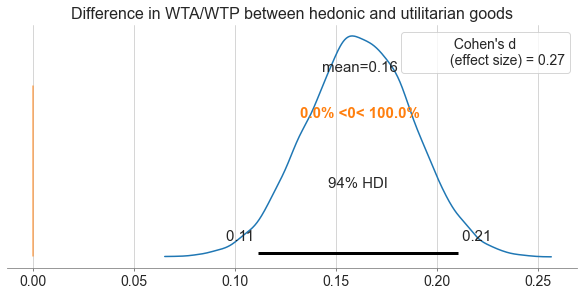

In [26]:
effect_size(type_idata)

In [31]:
def draw_alternative(type_idata):
    _, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)

    az.plot_posterior(type_idata, transform = np.exp, var_names = ['mu'], coords={'GoodType':['Hedonic']}, ax=ax, color = 'orange');
    az.plot_posterior(type_idata, transform = np.exp, var_names = ['mu'], coords={'GoodType':['Utilitarian']}, ax=ax, color = 'blue');
    mus = np.array(np.exp(type_idata.posterior.mu.mean(dim=("chain", "draw"))))
    ax.vlines(mus[0], 0,20, 'orange',linestyle='dashed',label=f"mean WTA/WTP hedonic")
    ax.vlines(mus[1], 0,20, 'blue',linestyle='dashed', label=f"mean WTA/WTP utilitarian")
    ax.legend(fontsize=14);
    ax.set_title(f'Posterior distribution of WTA/WTP for hedonic and utilitarian goods\n', size = 16);  
    plt.savefig('imgs/'+ 'diffWTAP.jpg',format='jpeg',dpi=300, bbox_inches = 'tight')

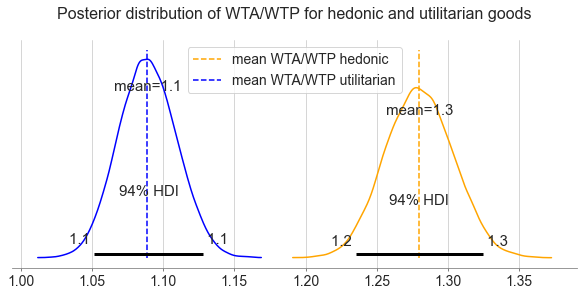

In [32]:
draw_alternative(type_idata)

### Comparison of lognormal and normal approximation


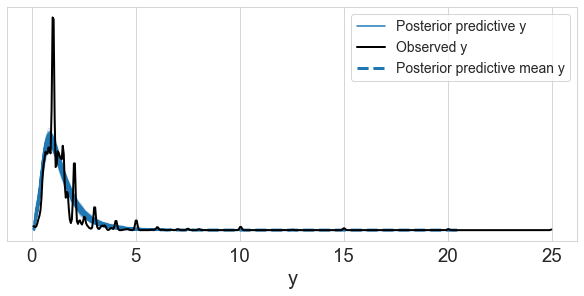

In [34]:
az.plot_ppc(type_idata, num_pp_samples=500, data_pairs={"y":"y"}, figsize = (8,4));
plt.savefig('imgs/'+ 'PPcheckWTAP.jpg',dpi = 300, format='jpeg', bbox_inches = 'tight')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 17 seconds.


0, dim: obs_id, 2012 =? 2012


0, dim: obs_id, 2012 =? 2012


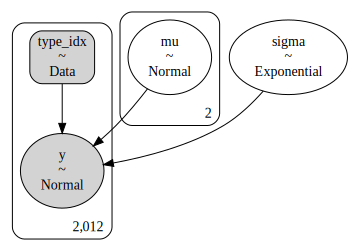

In [35]:
with pm.Model(coords=coords) as type_model_normal:
    type_idx = pm.Data("type_idx", df.TypeCode.values, dims="obs_id")
    mu = pm.Normal("mu", 1, sigma=1, dims="GoodType")
    sigma = pm.Exponential('sigma', 2)
    y = pm.Normal("y", mu[type_idx], sigma=sigma, observed=df['WTA/WTP'].values, dims="obs_id")
    type_trace = pm.sample(4000, tune=1000, init="adapt_diag")
    ppc = pm.sample_posterior_predictive(type_trace)
    type_idata_normal = az.from_pymc3(type_trace, posterior_predictive=ppc)
pm.model_to_graphviz(type_model_normal)

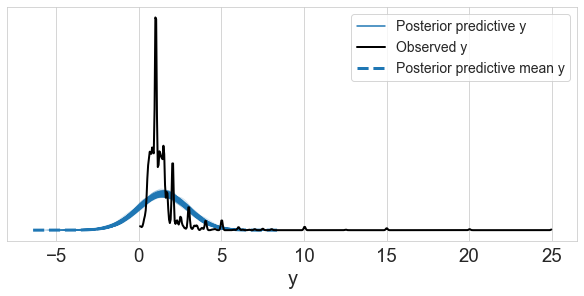

In [36]:
az.plot_ppc(type_idata_normal, num_pp_samples=500, data_pairs={"y":"y"}, figsize = (8,4));

In [41]:
az.compare({'normal': type_idata_normal, 'lognormal': type_idata})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
lognormal,0,-2126.725794,4.661759,0.000000,0.993707,62.163392,0.000000,False,log
normal,1,-3640.063641,39.860073,1513.337846,0.006293,208.479377,173.555015,True,log


***Conslusion***: lognormal approximation much better and suitable here

## Testosterone effect exploration

Suppose that wta/wtp ratio came from Lognormal distribution (despite the outliers and assimetry). 
We used hierarchical linear model for endowment effects modelling taking into account individuals and items variation
$$log(WTA/WTP[i,j]) = a_{0}+b*Tchange+\alpha_{Ind[j]]}+ g_{goods[i]}$$ 



In [37]:
coords = {"Item": list(df.Item.unique()), "GoodType": ["Hedonic", "Utilitarian"],
          "Subj": list(df.Subjects.unique()) ,"obs_id": np.arange(df.Item.size)}

with pm.Model(coords=coords) as endw_test_lognormal:
    
    ind_idx = pm.Data("ind_idx", df.SubjectsCode.values, dims="obs_id")
    item_idx = pm.Data("item_idx", df.ItemCodes.values, dims="obs_id")
    tpl_change = pm.Data("tpl_change", df.TPl_change, dims="obs_id")
    ##hyperpriors
    alpha_bar = pm.Normal("alpha_bar", 0, 0.5)
    sigma_ind = pm.Exponential("sigma_ind", 2.0)
    sigma_g = pm.Exponential("sigma_g", 2.0)

    z_ind = pm.Normal("z_ind", 0.0, 1.0, dims="Subj") #dims="Item"
    z_item = pm.Normal("z_item", 0.0, 1.0, dims = "Item")
    #model error
    sigma = pm.Exponential("sigma", 1.0)
    
    #testosterone related coef
    beta = pm.Normal("beta", 0, 0.5, dims = "Item")


    ratio  = alpha_bar+z_item[item_idx]*sigma_g+beta[item_idx]*tpl_change+z_ind[ind_idx]*sigma_ind
    mu_item = pm.Deterministic('mu_item', alpha_bar+z_item*sigma_g, dims = "Item")

    #ratio_pl = pm.Deterministic('ratio_pl', alpha_bar+z_item[item_idx]*sigma_g, dims = "Item")
    #ratio_t1 = pm.Deterministic('ratio_t1', alpha_bar+z_item[item_idx]*sigma_g+beta[item_idx], dims = "Item")

    y = pm.Lognormal('y', mu=ratio, sd=sigma, observed=df['WTAPcorr'].values, dims="obs_id")
    endw_trace = pm.sample(4000, tune=1000, init="adapt_diag")
    ppc = pm.sample_posterior_predictive(endw_trace)
    endw_idata_lognormal = az.from_pymc3(endw_trace, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, z_item, z_ind, sigma_g, sigma_ind, beta, alpha_bar]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 40 seconds.


0, dim: obs_id, 2012 =? 2012


The number of effective samples is smaller than 25% for some parameters.


0, dim: obs_id, 2012 =? 2012


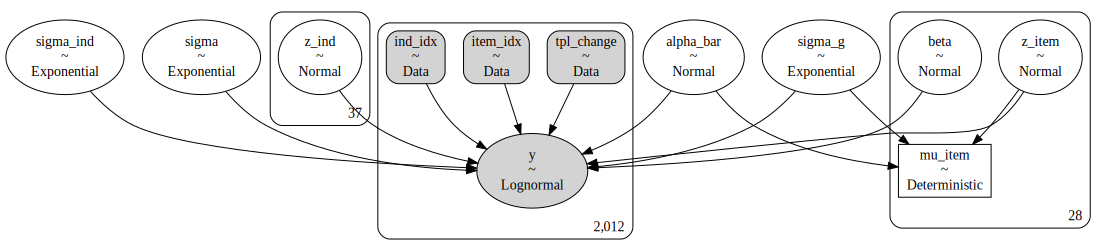

In [38]:
pm.model_to_graphviz(endw_test_lognormal)

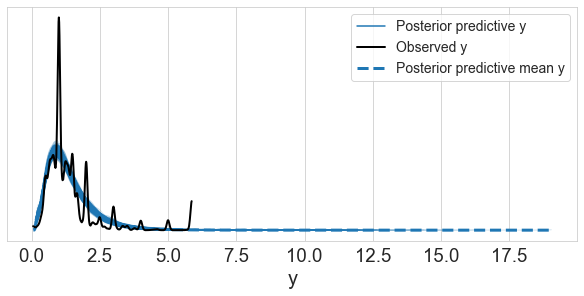

In [39]:
az.plot_ppc(endw_idata_lognormal, num_pp_samples=500, data_pairs={"y":"y"}, figsize = (8,4));
plt.savefig('imgs/'+ 'PPcheckInd.jpg',dpi = 300, format='jpeg', bbox_inches = 'tight')

### Endowment effect for separate items




Additionally, using this model we can explore the value of endowment effect for each item. Photos of items: https://osf.io/8ubk3/


In [40]:
hedonic = list(df[df.TypeCode==0].Item.unique())
utilitarian = list(df[df.TypeCode==1].Item.unique())

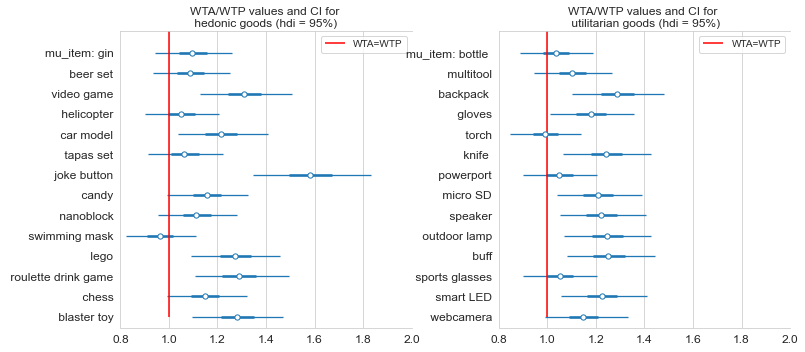

In [41]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
az.plot_forest(
    endw_idata_lognormal, var_names=["mu_item"], transform = np.exp, coords={'Item': hedonic}, textsize=12, markersize=7, combined=True, ax=axs[0]);
axs[0].set_title('WTA/WTP values and CI for \n hedonic goods (hdi = 95%) ');
az.plot_forest(
    endw_idata_lognormal, var_names=["mu_item"], transform = np.exp, coords={'Item': utilitarian}, textsize=12, markersize=7, combined=True, ax=axs[1]);
axs[1].set_title('WTA/WTP values and CI for \n utilitarian goods (hdi = 95%)');

for i in [0,1]:
    axs[i].vlines(1, 0, 12, 'red', label = 'WTA=WTP');
    axs[i].legend()
    axs[i].set_xlim(0.8,2)

plt.subplots_adjust(wspace = 0.3, top = 0.95)
plt.savefig('imgs/'+ 'WTAPciInd.jpg',dpi = 300, format='jpeg', bbox_inches = 'tight')

#### Testosterone related shift

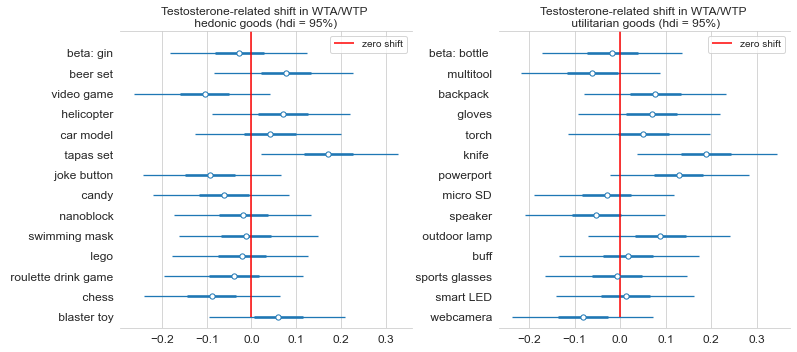

In [42]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
az.plot_forest(
    endw_idata_lognormal, var_names=["beta"], coords={'Item': hedonic}, textsize=12, markersize=7, combined=True, ax=axs[0]);
axs[0].set_title('Testosterone-related shift in WTA/WTP \n hedonic goods (hdi = 95%) ');
az.plot_forest(
    endw_idata_lognormal, var_names=["beta"], coords={'Item': utilitarian}, textsize=12, markersize=7, combined=True, ax=axs[1]);
axs[1].set_title('Testosterone-related shift in WTA/WTP \n utilitarian goods (hdi = 95%)');

for i in [0,1]:
    axs[i].vlines(0, 0, 12, 'red', label = 'zero shift');
    axs[i].legend()

plt.subplots_adjust(wspace = 0.3, top = 0.95)
plt.savefig('imgs/'+ 'TestWTAPciInd.jpg',dpi = 300, format='jpeg', bbox_inches = 'tight')